In this notebook, we apply GMM-MI to calculate the MI between categorical and continuous variables. We will use the the [3D Shapes dataset](https://github.com/deepmind/3d-shapes), on which we have pre-trained a $\beta$-variational autoencoder with 6 latents. We provide the categorical variables and the latents in a specific format:

- `latents` has shape `(n_samples, n_latents)`, and is obtained by feeding the data, and sampling one point from each latent distribution.

- `categories` has shape `(n_samples, n_categories)`, and is obtained by indicating for each data point what is the discrete value assumed by each category.

The total number of MI values calculated is `n_latents x n_categories`, and will be `6 x 6 = 36` in this notebook. We used `n_samples = 48000`, i.e. the test set with 10% of the data available. We also use as input a dictionary `dict_labels`, indicating each category and the number of values it can assume.

### Import packages

In [10]:
import numpy as np
import os
from gmm_mi.mi import EstimateMI
from gmm_mi.param_holders import GMMFitParamHolder, SelectComponentsParamHolder, MIDistParamHolder
from gmm_mi.utils.plotting import create_heatmap, annotate_heatmap

### Load the categorical variables and latents

In [11]:
category_list = ['floor_hue', 'object_hue', 'orientation', 'scale', 'shape', 'wall_hue']
categories = np.load('./3D_shapes_data/categories.npy')
# from pre-trained beta-VAE model
latents = np.load('./3D_shapes_data/latents.npy')
n_latents = latents.shape[1]

### Calculate MI for all latents and categories

In [12]:
# all unspecified parameters are set to their default values

# parameters for every GMM fit that is being run
gmm_fit_params = GMMFitParamHolder(threshold_fit=1e-5,
                                   reg_covar=1e-15)

# parameters to choose the number of components
select_components_params = SelectComponentsParamHolder(n_inits=5,
                                                       n_folds=3)

# parameters for MI distribution estimation
mi_dist_params = MIDistParamHolder(n_bootstrap=100,
                                   MC_samples=1e5)

In [13]:
results_file = f'./results/MI_3D_shapes.npy'

if os.path.isfile(results_file) :
    print('Not running this cell, since results file already exists. '
          'Loading pre-computed results...')
    all_MI_estimates = np.load(results_file)
else:
    print(f'Estimating MI, and saving results...')
    all_MI_estimates = np.zeros((len(category_list), n_latents, 2))
   
    for category_id, category in enumerate(category_list):
        for latent_id in range(n_latents):
            # get current continuous feature (a latent)
            current_cont_feat = latents[:, latent_id]
            # get current category           
            current_cat_feat = categories[:, category_id]
            
            mi_estimator = EstimateMI(gmm_fit_params=gmm_fit_params,
                                      select_components_params=select_components_params,
                                      mi_dist_params=mi_dist_params)
            MI_mean, MI_std = mi_estimator.fit_categorical(X=current_cont_feat,
                                                           y=current_cat_feat)   
            
            all_MI_estimates[category_id, latent_id, 0] = MI_mean
            all_MI_estimates[category_id, latent_id, 1] = MI_std

            np.save(results_file, all_MI_estimates)

Not running this cell, since results file already exists. Loading pre-computed results...


### Plot results

In [14]:
y_labels = [label.capitalize().replace("_", " ") for label in category_list]
x_labels = [f"$z_{i}$" for i in range(1, 7)]#[f"$z_{i+$" for i in range(6)]
# we only look at the mean MI values for this plot, so we ignore the MI uncertainty
MI_values = all_MI_estimates[:, :, 0]

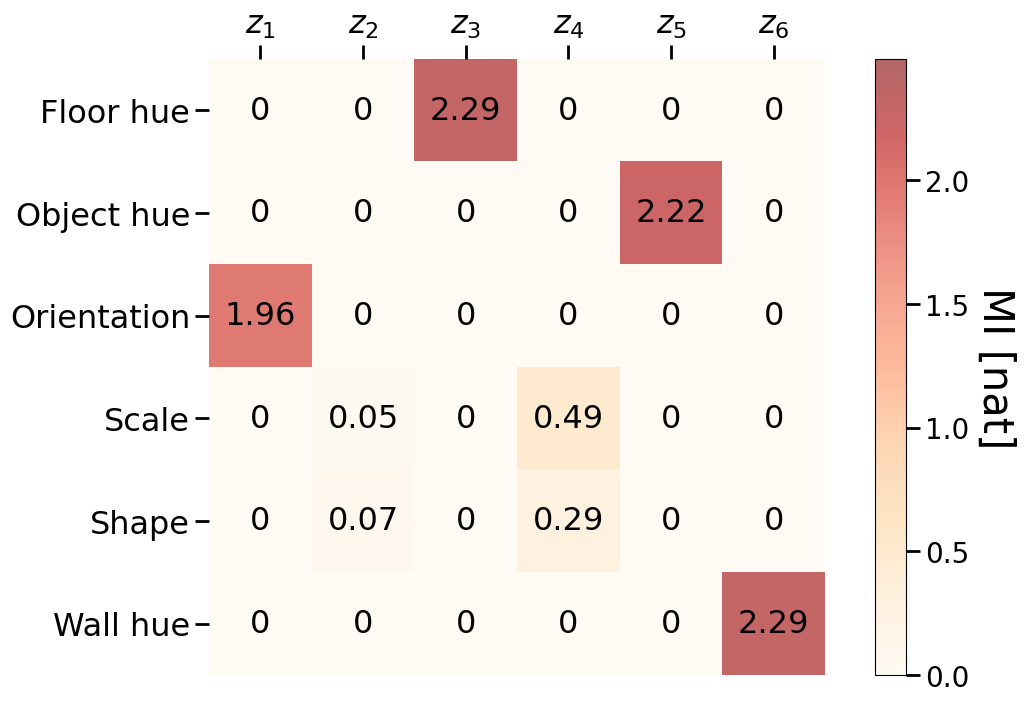

In [18]:
im, cbar = create_heatmap(MI_values, y_labels, x_labels, cmap="OrRd", 
                          cbarlabel="MI [nat]", alpha=0.6, fsize=23, vmin=0, vmax=2.49)
texts = annotate_heatmap(im, valfmt="{x:.2f}", save_fig=True, 
                         save_path='./figures/MI_shapes3D_hm.pdf',
                         fontsize=23)

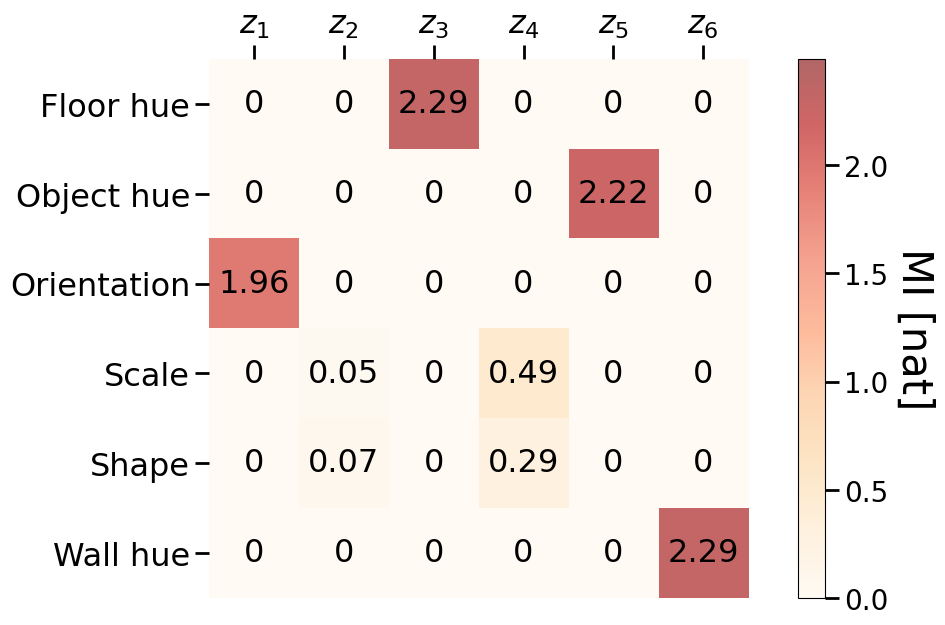

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(24, 7))
im, cbar = create_heatmap(MI_values, y_labels, x_labels, cmap="OrRd", 
                          cbarlabel="MI [nat]", alpha=0.6, fsize=23, ax=ax, vmin=0, vmax=2.49)
texts = annotate_heatmap(im, valfmt="{x:.2f}", save_fig=True, 
                         save_path='./figures/MI_shapes3D_hm_NeurIPS.pdf',
                         fontsize=23)